We are testing the performance of different attack parameters below, using the actions and clean observations from the optimal BB attack. Because the ASR was 1 we effectively have a sample and label for every timestep, where the previous action lead to the next clean observation. We can treat this as a supervised learning problem since we effectively have a label for each observation/sample. Unlike the untargeted attack, the actions are not chsen randomly. Given that CityLearn is deterministic we expect that the optinal adversarial trace is also deterministic (confirm with multiple runs) in terms of the action associated with each observation. 

From below: 
- Does the vecorized search work for more than one sample input at the same time (that's how their input for rl, here it gets thousands at a time)
- Increasing the batchsize has a significant effect on speed
- we don't have an init for action 18, does that correspond to the incorrect preds?

This copy used ramdoms.uniform in mybb

In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500.zip'
ATTACK = 'myBB'


In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion.brendel_bethge import BrendelBethgeAttack as BBA

import pandas as pd
import numpy as np
import os

import KBMproject.utilities as utils

from joblib import Parallel, delayed

%matplotlib inline

In [3]:
import logging
logging.basicConfig(level=logging.WARN)

Define RL agent

In [4]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [5]:
from art.estimators.classification import PyTorchClassifier as classifier
from torch.nn import CrossEntropyLoss
victim_policy = classifier(
    model=utils.extract_actor(agent),
    loss=CrossEntropyLoss(), 
    nb_classes=agent.action_space[0].n,
    input_shape=agent.observation_space.shape,
    device_type='gpu',
    clip_values = (agent.observation_space.low.min(),agent.observation_space.high.max()) #min and max values of each feature, brendle bethge attack only supports floats values and not array
    )

In [6]:
mask_time = np.ones(agent.observation_space.shape)
mask_time[:6] = 0

In [7]:
df_baseline = pd.concat([pd.read_csv('baseline_obs.csv', index_col=0,dtype='float32'),
                        pd.read_csv('baseline_obs_a_confidence.csv', index_col=0)], axis='columns')

Below, for each action we select the sample with the highest logit softmax/confidence

In [8]:
df_max_confidence_samples = df_baseline.loc[df_baseline.groupby('action')['confidence'].idxmax()]
df_max_confidence_samples = df_max_confidence_samples.drop(columns='confidence')
df_max_confidence_samples = df_max_confidence_samples.set_index('action')

In [9]:
dict_samples = df_max_confidence_samples.T.to_dict()

In [10]:
samples = pd.read_csv('bb results/optimal myBB observations.csv', index_col=0,dtype='float32')

In [11]:
inputs = samples.to_numpy()[:-1]

In [12]:
targets = np.argmax(victim_policy.predict(pd.read_csv('bb results/optimal myBB adversarial observations.csv',
                                            index_col=0,
                                            dtype='float32')
                                            ), axis=1)

In [13]:
starts = np.array([np.array(list(
    dict_samples[a].values())).astype('float32') if a in dict_samples else np.zeros(agent.observation_space.shape, 'float32') for a in targets]) #there is no example for action 18

In [13]:
kwargs = dict(norm=2,
        targeted=True, #default false
        overshoot=1.1, #1.1,
        steps=1000,
        lr=1e-3,
        lr_decay=0.5,
        lr_num_decay=20,
        momentum=0.8,
        binary_search_steps=10,
        init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
        #batch_size=1, this makes it soooooo much worse, increasing it to 1000 seems to sligthly decrease the computation time
        )
l2_attack = BBA(estimator=victim_policy, **kwargs)

In [14]:
%%time
l2_adv_samples = l2_attack.generate(x=samples.to_numpy()[:-1], 
                         y=targets, 
                         x_adv_init=starts, 
                         mask=mask_time)

CPU times: total: 57min 21s
Wall time: 21min 13s


In [15]:
l2_adv_preds = victim_policy.predict(l2_adv_samples)

In [16]:
l2_adv_preds = np.argmax(l2_adv_preds, axis=1)

ASR

In [17]:
np.count_nonzero(l2_adv_preds == targets)/l2_adv_samples.shape[0]

0.8857175476652586

In [18]:
np.count_nonzero((l2_adv_samples != inputs).all(axis=1))

462

In [19]:
adv_diff = l2_adv_samples- inputs

In [20]:
l2_norms = np.linalg.norm(adv_diff, ord=2, axis=1)

In [21]:
linf_norms =  np.linalg.norm(adv_diff, ord=np.inf, axis=1)

In [22]:
df_norms = pd.DataFrame({'L2':l2_norms,'Linf':linf_norms})

<Axes: title={'center': 'KDE of norms for an L2 BB Attack'}, ylabel='Density'>

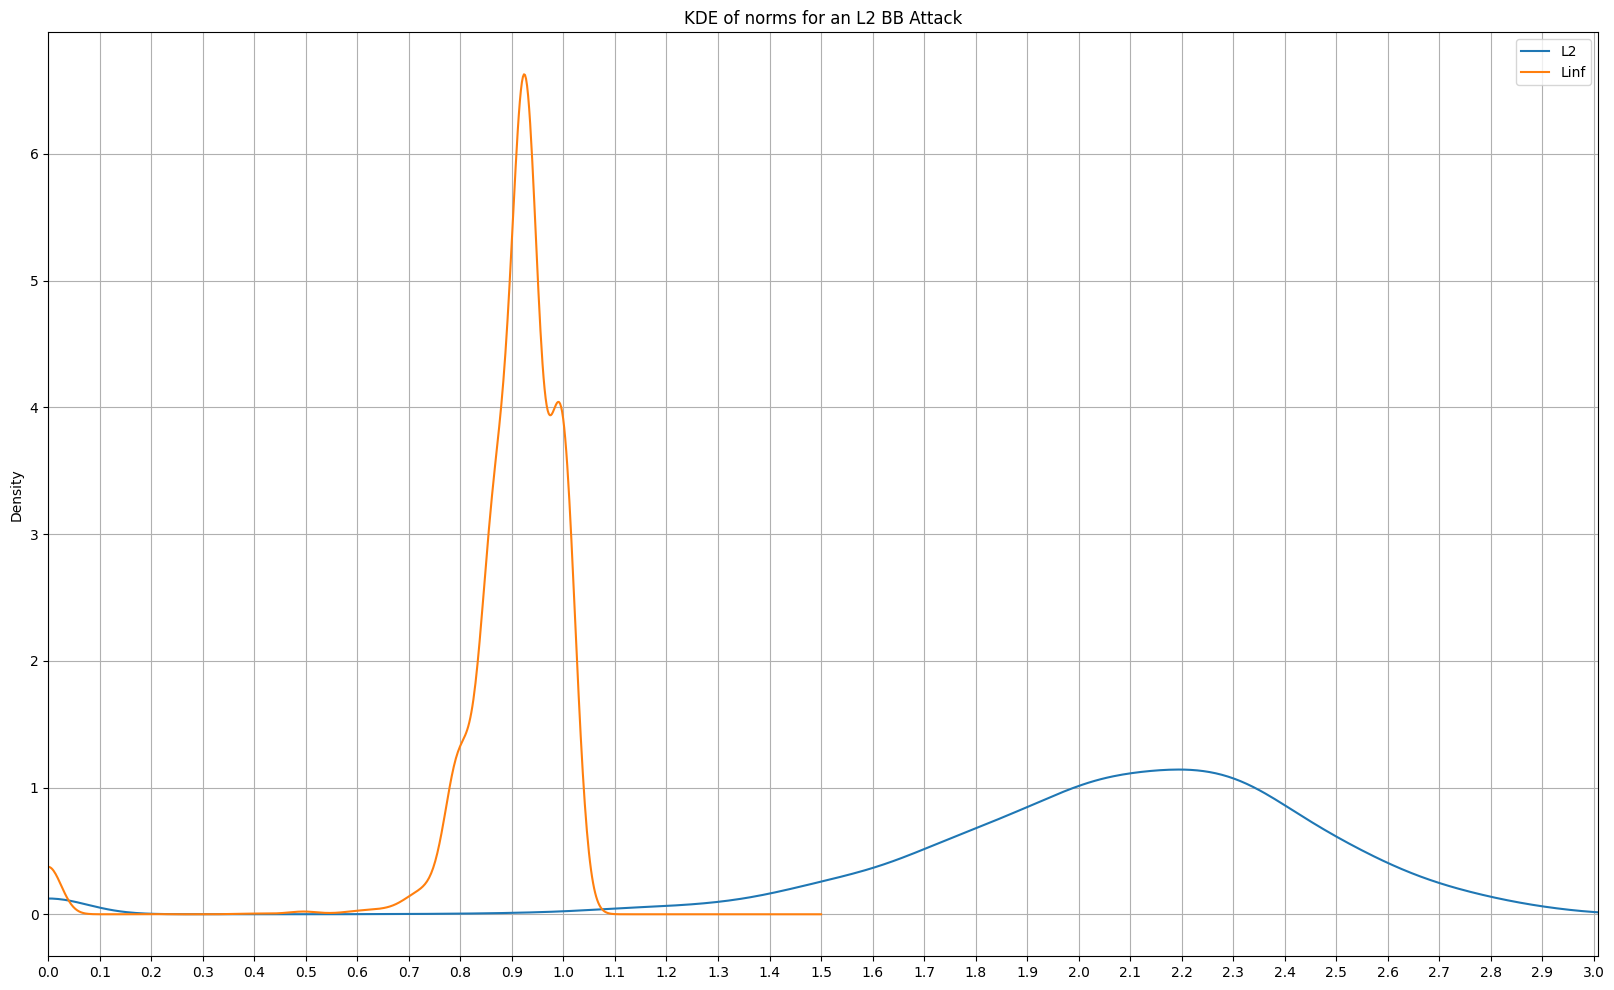

In [23]:
df_norms.plot.kde(grid=True, 
                   xticks=np.arange(start=df_norms.min().min(), stop=df_norms.max().max(), step=0.1),
                   figsize=(20,12),
                   xlim=[df_norms.min().min(),df_norms.max().max()], #NB the max/min of a df is a series, and we need the max/min of the series
                   title='KDE of norms for an L2 BB Attack',
                   xlabel='Linf Norms',
                   legend=True
                   )

We see that the norms for this attack are much higher than for bb linf, and the ASR is lower, this suggests that this attack is less effective are more detectable. NB that a norm of 0 indicates where the attack failed to generate and adversarial sample. 

In [24]:
%%time
l2_adv_noinit_samples = l2_attack.generate(x=samples.to_numpy()[:-1], 
                         y=targets, 
                         #x_adv_init=starts, 
                         mask=mask_time)

CPU times: total: 57min 7s
Wall time: 21min


ASR for target reshaped l2 attack

In [25]:
l2_adv_noinit_preds = np.argmax(victim_policy.predict(l2_adv_noinit_samples), axis=1)
np.count_nonzero(l2_adv_noinit_preds == targets)/l2_adv_noinit_samples.shape[0]

0.8868592305057655

In [28]:
df_norms.describe()

,L2,Linf
count,8759.000000,8759.000000
mean,2.048068,0.894038
std,0.467463,0.155405
min,0.000000,0.000000
25%,1.858843,0.878788
50%,2.111439,0.922743
75%,2.329404,0.969697
max,3.008110,1.000000


In [14]:
kwargs = dict(norm=np.inf,
        targeted=True, #default false
        overshoot=1.1, #1.1,
        steps=1000,
        lr=1e-3,
        lr_decay=0.5,
        lr_num_decay=20,
        momentum=0.8,
        binary_search_steps=10,
        init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
        #batch_size=1000,
        )
linf_attack = BBA(estimator=victim_policy, **kwargs)

In [15]:
%%time
linf_adv_samples = linf_attack.generate(x=inputs, 
                         y=targets, 
                         x_adv_init=starts, 
                         mask=mask_time)

CPU times: total: 1h 57min 28s
Wall time: 1h 21min 26s


Linf ASR

In [17]:
linf_adv_preds = np.argmax(victim_policy.predict(linf_adv_samples), axis=1)
np.count_nonzero(linf_adv_preds == targets)/inputs.shape[0]

0.9163146477908437

In [19]:
%%time
linf2_adv_samples = linf_attack.generate(x=inputs, 
                         y=targets, 
                         #x_adv_init=starts, #faster without these?! because the attack wasn't running after a failed search?
                         mask=mask_time)

KeyboardInterrupt: 

Linf ASR

In [ ]:
linf2_adv_preds = np.argmax(victim_policy.predict(linf2_adv_samples), axis=1)
np.count_nonzero(linf2_adv_preds == targets)/inputs.shape[0]